In [1]:
library(Augur)
library(dplyr)
library(ggplot2)
library(ggpubr)

reg_ord <- c("FC","MSC","OC","TC")
all_pairs <- combn(reg_ord, 2)
all_pairs

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




FC,FC,FC,MSC,MSC,OC
MSC,OC,TC,OC,TC,TC


In [2]:
## Load the Augur data
data_upper <- lapply(c("E77-78", "E93", "E110"), function(ag) {
        print(ag)
        ag_res <- lapply(1:ncol(all_pairs), function(x) {
            reg1 <- all_pairs[1, ][x]
            reg2 <- all_pairs[2, ][x]
            
            ## specifically change the order for TC/OC
            if (reg1 == "OC" & reg2 == "TC"){
                augFile <- paste0("./load_files/", "Augur_res/Augur_rawRes_upper_", ag, ".", reg2, ".", reg1, ".rds")
            } else {
                augFile <- paste0("./load_files/", "Augur_res/Augur_rawRes_upper_", ag, ".", reg1, ".", reg2, ".rds")
            }
            
            augres <- readRDS(file = augFile)$AUC %>%
                        mutate(region1 = reg1, region2 = reg2, age = ag)
        }) %>%
        do.call(rbind, .)

        return(ag_res)
        }) %>%
        do.call(rbind, .)
head(data_upper)
sum(is.na(data_upper))

[1] "E77-78"
[1] "E93"
[1] "E110"


cell_type,auc,region1,region2,age
<chr>,<dbl>,<chr>,<chr>,<chr>
IPC EOMES NHLH1 up,0.8575794,FC,MSC,E77-78
ExN CUX2 ADRA2A,0.8080971,FC,MSC,E77-78
ExN CUX2 PALMD,0.7564758,FC,MSC,E77-78
ExN CUX2 ADRA2A,0.8882256,FC,OC,E77-78
IPC EOMES NHLH1 up,0.8450548,FC,OC,E77-78
ExN CUX2 PALMD,0.8003023,FC,OC,E77-78


[1] 0

In [3]:
data_deep <- lapply(c("E54", "E62-64"), function(ag) {
        print(ag)
        ag_res <- lapply(1:ncol(all_pairs), function(x) {
            reg1 <- all_pairs[1, ][x]
            reg2 <- all_pairs[2, ][x]
            ## specifically change the order for TC/OC
            if (reg1 == "OC" & reg2 == "TC"){
                augFile <- paste0("./load_files/", "Augur_res/Augur_rawRes_deep_", ag, ".", reg2, ".", reg1, ".rds")
            } else {
                augFile <- paste0("./load_files/", "Augur_res/Augur_rawRes_deep_", ag, ".", reg1, ".", reg2, ".rds")
            }
            augres <- readRDS(file = augFile)$AUC %>%
                        mutate(region1 = reg1, region2 = reg2, age = ag)
        }) %>%
        do.call(rbind, .)

        return(ag_res)
        }) %>%
        do.call(rbind, .)
head(data_deep)
sum(is.na(data_deep))

[1] "E54"
[1] "E62-64"


cell_type,auc,region1,region2,age
<chr>,<dbl>,<chr>,<chr>,<chr>
ExN SOX5 NR4A2 GRID2,0.9125964,FC,MSC,E54
ExN SOX5 SYT6,0.9014739,FC,MSC,E54
IPC EOMES NHLH1 deep,0.8100113,FC,MSC,E54
IPC EOMES NEUROG1,0.8087491,FC,MSC,E54
ExN SOX5 PALMD,0.7901909,FC,MSC,E54
ExN SOX5 SYT6,0.9562132,FC,OC,E54


[1] 0

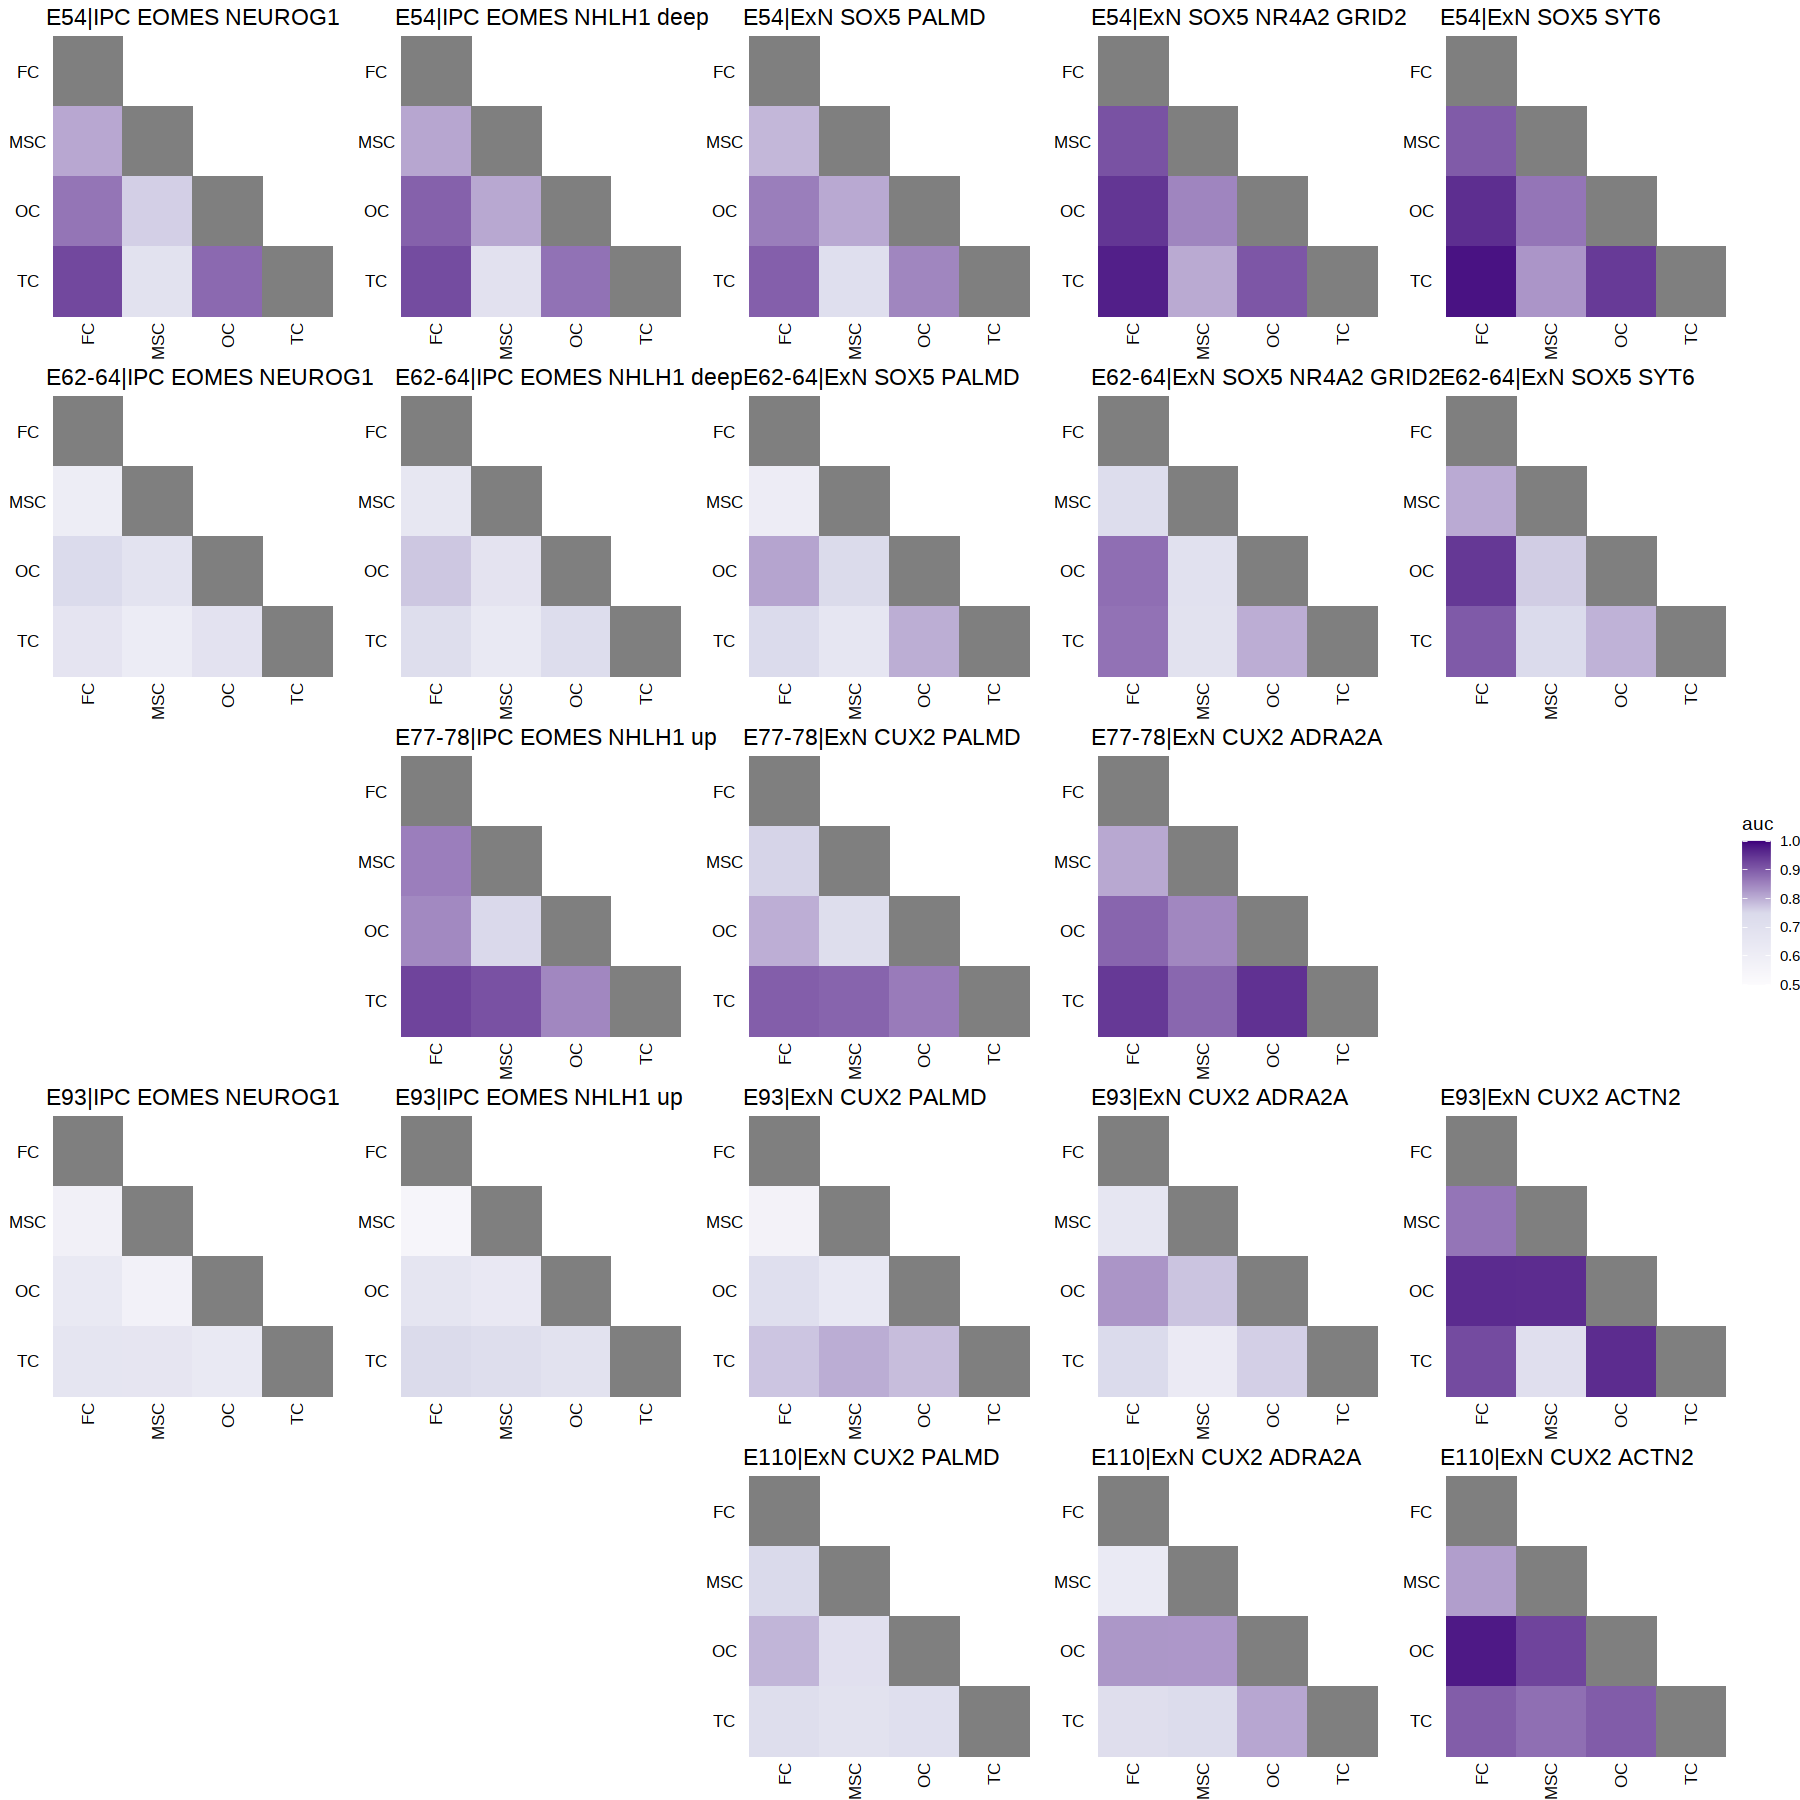

In [4]:
pdata <- rbind(data_upper, data_deep) %>%
            mutate(region1 = factor(region1, levels = reg_ord)) %>%
            mutate(region2 = factor(region2, levels = reg_ord)) 
pdata$auc[pdata$auc < 0.5] <- 0.5
pdata$auc[pdata$auc > 1] <- 1


## Plot half heatmap
plist <- lapply(c("E54", "E62-64", "E77-78", "E93", "E110"), function(ag) {
        agdata <- filter(pdata, age == ag)
        if (ag %in% c("E54", "E62-64")){
            cls_ord <- c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 deep", 
                         "ExN SOX5 PALMD", "ExN SOX5 NR4A2 GRID2", "ExN SOX5 SYT6") 
            ## "ExN SOX5 ID2" merged to "ExN SOX5 PALMD", considered as nascent deep layer neurons
        } else {
            cls_ord <- c("IPC EOMES NEUROG1", "IPC EOMES NHLH1 up", 
                         "ExN CUX2 PALMD", "ExN CUX2 ADRA2A", "ExN CUX2 ACTN2")
        }

        cls_use <- intersect(cls_ord, unique(agdata$cell_type))
        aglist <- lapply(cls_ord, function(cls) {
            if (cls %in% cls_use){
                subdata <- filter(agdata, cell_type == cls)
                ## Transform the data to a triangle data
                mat <- matrix(0, nrow = length(reg_ord), ncol = length(reg_ord), dimnames = list(reg_ord, reg_ord))
                for (i in 1:nrow(subdata)){
                    reg1 <- subdata$region1[i]
                    reg2 <- subdata$region2[i]
                    mat[reg1, reg2] <- subdata$auc[i]
                    mat[reg2, reg1] <- subdata$auc[i]
                }
                mat[lower.tri(mat, diag = FALSE)] <- NA
                ndata <- mat %>%
                        reshape2::melt() %>%
                        setNames(., c("region1", "region2", "auc")) %>%
                        mutate(region1 = factor(as.character(region1), levels = reg_ord)) %>%
                        mutate(region2 = factor(as.character(region2), levels = rev(reg_ord))) %>%
                        filter(!is.na(auc))
                ndata$auc[ndata$auc == 0] <- NA
                p <- ggplot(ndata, aes(x = region1, y = region2, fill = auc)) +
                        geom_tile(color = NA) +
                        theme_void()+
                        coord_fixed() +
                        labs(title = paste0(ag, "|", cls)) +
                        scale_fill_gradientn(colors = c("#fcfbfd", "#dadaeb", "#3f007d"), limits = c(0.5, 1)) +
                        theme(legend.position = "right", axis.text.y = element_text(size = rel(0.9)), 
                            axis.text.x = element_text(size = rel(0.9), angle = 90, hjust = 1))
            } else {
                p <- NULL
            }
            return(p)
            })
        return(aglist)
        }) %>%
        do.call(c, .)
pcbn <- ggarrange(plotlist = plist, nrow = 5, ncol = 5, common.legend = TRUE, legend = "right")
options(repr.plot.width=15, repr.plot.height=15)
pcbn

In [5]:
pdf(paste0("./report/", "Augur_ExN_results_v2.pdf"), width = 15, height = 15)
print(pcbn)
dev.off()


png 
  2

In [6]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.3.0  ggplot2_3.3.0 dplyr_1.0.7   Augur_1.0.2  

loaded via a namespace (and not attached):
  [1] nlme_3.1-147            matrixStats_0.58.0      lubridate_1.7.8        
  [4] repr_1.1.6              tools_3.6.1             backports_1.1.6        
 